In [223]:
import matplotlib.pyplot as plt

In [224]:
import numpy as np

In [225]:
import cv2

In [226]:
def plot_spectrum(spectrum):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.log10(np.abs(spectrum)), cmap='gray')
    plt.show()

In [227]:
def plot_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.show()

# Cargando la imagen

In [228]:
img = cv2.imread('../resources/clown.jpg', cv2.IMREAD_GRAYSCALE)

In [229]:
img = img / 255

# Visualizando la imagen

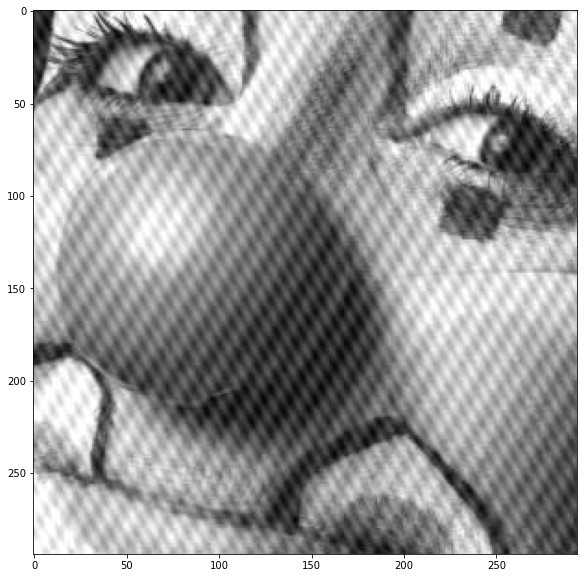

In [230]:
plot_image(img)

# Visualizando el espectro de la imagen

In [231]:
img_spectrum = np.fft.fftshift(np.fft.fft2(img))

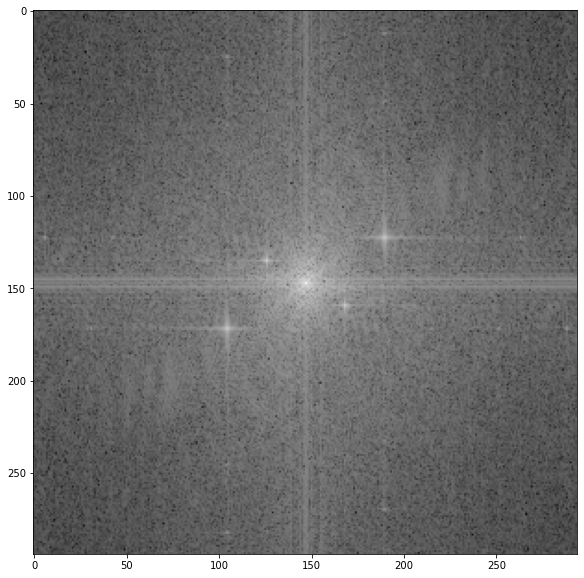

In [232]:
plot_spectrum(img_spectrum)

# Filtrando con un rechazabanda ideal

In [233]:
def distance(x, y, cx, cy):
    return (x - cx)**2 + (y - cy)**2

In [402]:
N, M = img.shape
img_ideal_spectrum = np.zeros((N, M), dtype=np.complex)
for i in range(N):
    for j in range(M):
        if (distance(i, j, 105, 172) <  20):
            img_ideal_spectrum[j, i] = 0
        elif (distance(i, j, 190, 121) <  20):
            img_ideal_spectrum[j, i] = 0
        elif (distance(i, j, 168, 158) <  20):
            img_ideal_spectrum[j, i] = 0
        elif (distance(i, j, 125, 135) <  20):
            img_ideal_spectrum[j, i] = 0
        else:
            img_ideal_spectrum[j, i] = img_spectrum[j, i]

In [403]:
img_ideal = np.real(np.fft.ifft2(np.fft.fftshift(img_ideal_spectrum)))

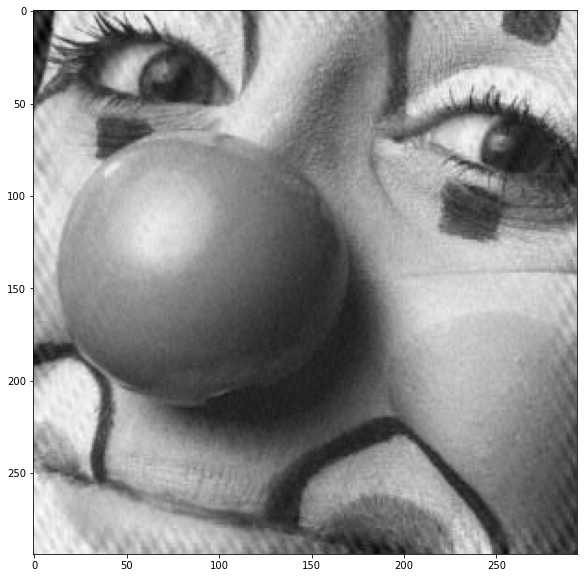

In [404]:
plot_image(img_ideal)

<ipython-input-226-368313307c1d>:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(spectrum)), cmap='gray')


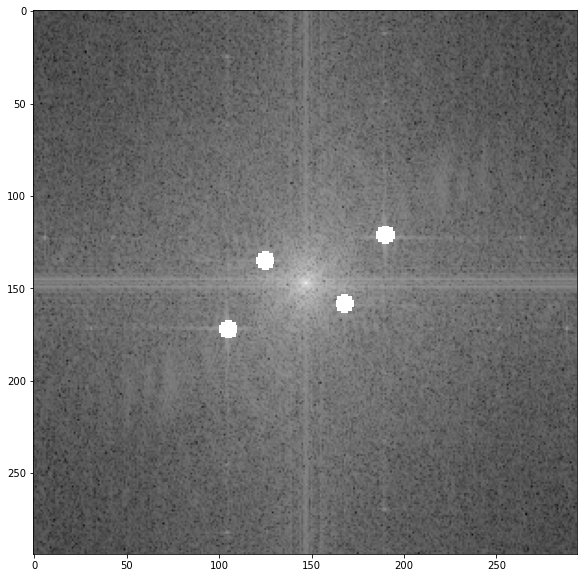

In [405]:
plot_spectrum(img_ideal_spectrum)

# Filtrando con un gaussiano

In [375]:
def get_notch(cx, cy, size, gamma_h=0.2, gamma_l=3.0, c=1, D0=0.068):
    d = np.array([np.sqrt((np.array(range(size)) - cx)**2 + (i - cy)**2) for i in range(size)]).T
    H = (gamma_h - gamma_l) * (1 - np.exp(-c * d**2 / (D0 * size)**2)) + gamma_l
    H = np.interp(H, (H.min(), H.max()), (H.min(), 1))
    H = (H.max() - H)
    H /= H.max()
    return H

In [376]:
notch_1 = get_notch(172, 105, 294)

In [393]:
notch_2 = get_notch(123, 190, 294)

In [394]:
notch_3 = get_notch(158, 168, 294)

In [395]:
notch_4 = get_notch(135, 125, 294)

In [396]:
N, M = img.shape
img_notch_spectrum = np.zeros((N, M), dtype=np.complex)
for i in range(N):
    for j in range(M):
        img_notch_spectrum[j, i] = img_spectrum[j, i] * notch_1[j, i] * notch_2[j, i] * notch_3[j, i] * notch_4[j, i]

In [397]:
img_notch = np.abs(np.fft.ifft2(np.fft.fftshift(img_notch_spectrum)))

In [398]:
img_notch = np.array(img_notch * 255, dtype=np.uint8)

In [399]:
img_notch

array([[ 46,  38,  39, ..., 108, 101, 108],
       [ 31,   9,   3, ...,  95, 108, 134],
       [ 20,  16,  30, ...,  90, 106, 138],
       ...,
       [137, 107, 103, ...,  55,  47,   2],
       [137, 112, 113, ...,  18,   5,  25],
       [143, 131, 135, ...,  20,  30,  41]], dtype=uint8)

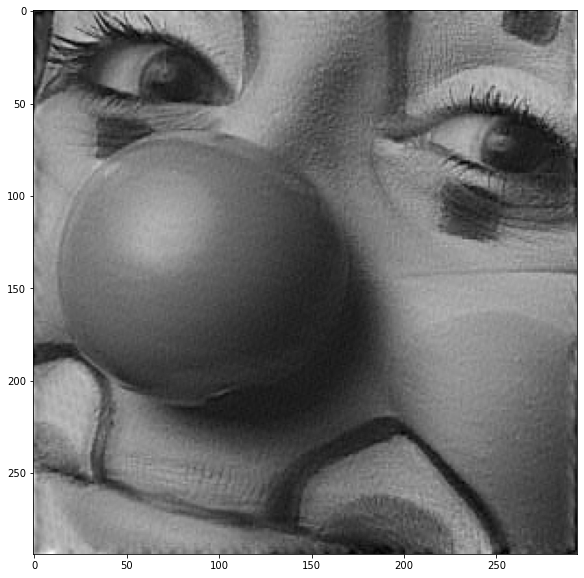

In [400]:
plot_image(img_notch)

<ipython-input-226-368313307c1d>:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(spectrum)), cmap='gray')


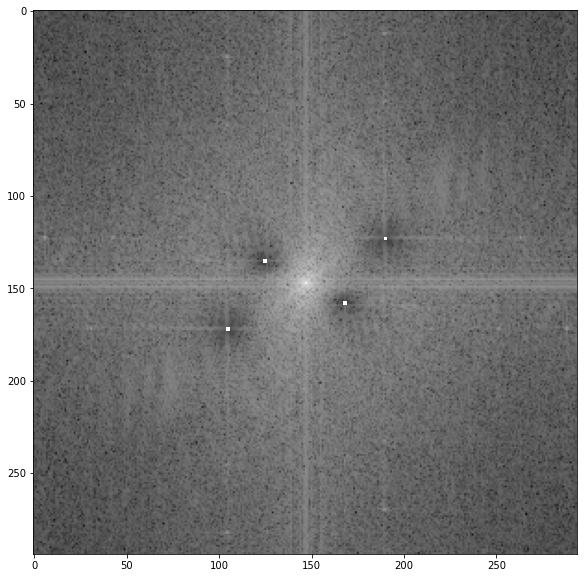

In [401]:
plot_spectrum(img_notch_spectrum)

# Ecualización

In [387]:
def apply_transformation(transformation, image):
    """ Apply a transformation function to all pixel of the given image
        @param transformation Transformation s = T(r)
        @param image Input image to be transformed
        @return Output image after transformation
    """
    return np.array(list(map(np.vectorize(transformation), image)), dtype=np.uint8)

In [388]:
pdf, bins = np.histogram(img_notch.flatten(), bins=img_notch.max()-img_notch.min(), density=True)

In [389]:
cdf = np.cumsum(pdf)

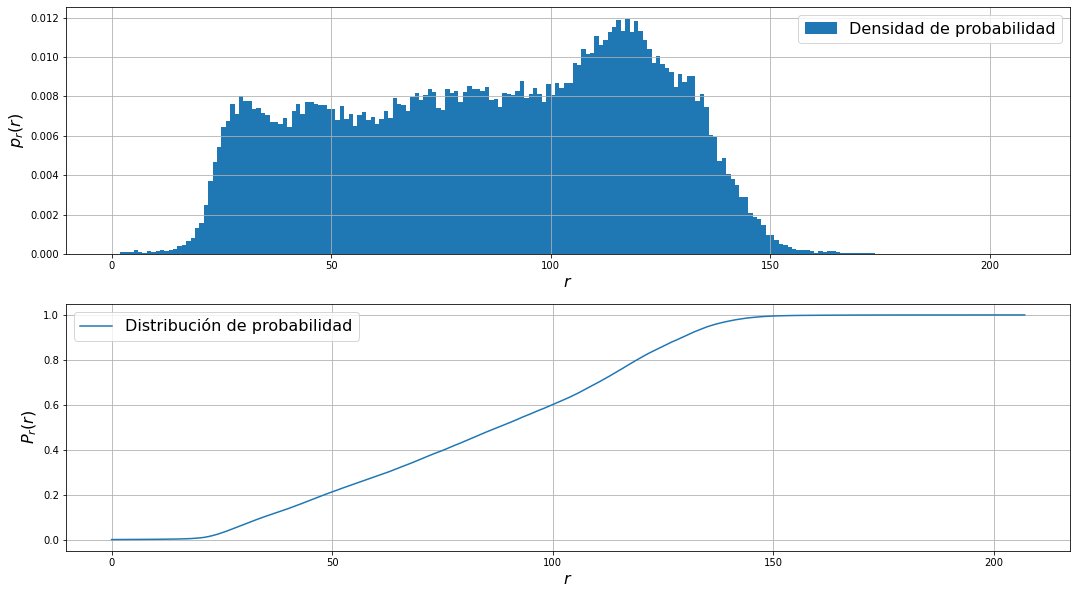

In [390]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

ax1.bar(bins[:-1]+0.5, pdf, width=1.0, label='Densidad de probabilidad')
ax1.set_xlabel('$r$', fontsize=16)
ax1.set_ylabel('$p_r(r)$', fontsize=16)
ax1.legend(fontsize=16)
ax1.grid()

ax2.plot(cdf, label='Distribución de probabilidad')
ax2.set_xlabel('$r$', fontsize=16)
ax2.set_ylabel('$P_r(r)$', fontsize=16)
ax2.legend(fontsize=16)
ax2.grid()

plt.show()

In [391]:
img_notch_eq = apply_transformation(lambda r: cdf[r - 1] * 200, img_notch)

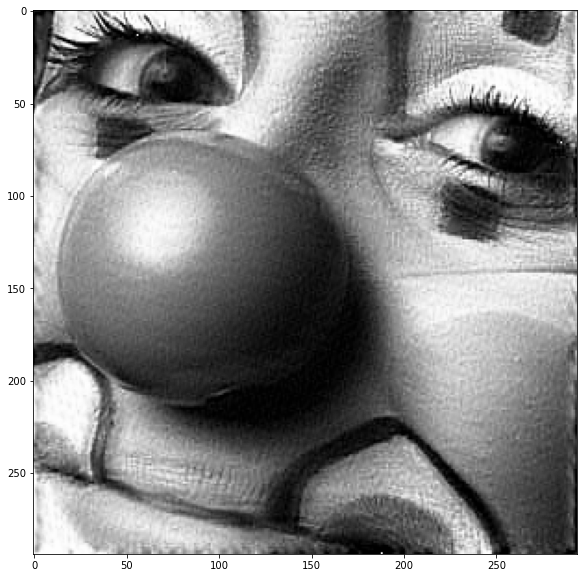

In [392]:
plot_image(img_notch_eq)